In [934]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import validation_curve
import time
import os
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [935]:
pre_df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [936]:
pre_df.head()

,arrivalDate,sailingDate,place.placeName,place.unlocode,place.placeType,place.countryName,Timestamp,Event_Type,IMO,vessel.vesselName,vessel.vesselType
0,2021-01-17T10:08:08,2021-01-20T03:44:00,Longkou Port,CNLKU,Port,People's Republic of China,2021-01-17T10:08:08,ARRIVAL,9337391,Athens Voyager,crude oil tanker
1,2021-01-17T10:08:08,2021-01-20T03:44:00,Longkou Port,CNLKU,Port,People's Republic of China,2021-01-20T03:44:00,DEPARTURE,9337391,Athens Voyager,crude oil tanker
2,2021-01-25T05:16:08,2021-01-27T02:04:05,Longkou Port,CNLKU,Port,People's Republic of China,2021-01-25T05:16:08,ARRIVAL,9337391,Athens Voyager,crude oil tanker
3,2021-01-25T05:16:08,2021-01-27T02:04:05,Longkou Port,CNLKU,Port,People's Republic of China,2021-01-27T02:04:05,DEPARTURE,9337391,Athens Voyager,crude oil tanker
4,2021-02-21T01:17:30,2021-02-22T23:00:19,Zhoushan Port,CNZOS,Port,People's Republic of China,2021-02-21T01:17:30,ARRIVAL,9337391,Athens Voyager,crude oil tanker


In [937]:
# preprocess data
# sort by imo number
pre_df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
pre_df['next_place'] = pre_df.groupby('IMO')['place.unlocode'].shift(-1)
pre_df['is_last_imo'] = pre_df['IMO'] != pre_df['IMO'].shift(-1)
pre_df = pre_df[~pre_df["is_last_imo"]]
pre_df = pre_df[pre_df["Event_Type"] != "ARRIVAL"]

In [938]:
pre_df = pre_df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate"])
pre_df

,place.placeName,place.unlocode,place.placeType,place.countryName,vessel.vesselType,next_place
314761,Los Angeles,USLAX,Port,United States of America,Vessel Type (unspecified),CNJGY
314763,Jiangyin,CNJGY,Port,People's Republic of China,Vessel Type (unspecified),CNTXG
314765,Tianjin Xingang Port,CNTXG,Port,People's Republic of China,Vessel Type (unspecified),CNQAW
314767,Qianwan,CNQAW,Sub Port,People's Republic of China,Vessel Type (unspecified),CNMSN
314769,Meishan,CNMSN,Sub Port,People's Republic of China,Vessel Type (unspecified),CNNSA
...,...,...,...,...,...,...
12569,Port Klang (Pelabuhan Klang),MYPKG,Port,Malaysia,fully cellular containership,INMAA
12571,Chennai (ex Madras),INMAA,Port,India,fully cellular containership,BDCGP
12573,Chittagong (Chattogram),BDCGP,Port,Bangladesh,fully cellular containership,THLCH
12575,Laem Chabang,THLCH,Port,Thailand,fully cellular containership,SGSIN


In [939]:
pre_df[['place.unlocode', 'next_place']].head(1000)

,place.unlocode,next_place
314761,USLAX,CNJGY
314763,CNJGY,CNTXG
314765,CNTXG,CNQAW
314767,CNQAW,CNMSN
314769,CNMSN,CNNSA
...,...,...
154945,USPEF,USTXT
154947,USTXT,USPEF
154949,USPEF,USHOU
154951,USHOU,USPEF


In [940]:
print(pre_df.isna().sum())
pre_df = pre_df.dropna(subset=['place.unlocode', 'next_place'])

place.placeName      0
place.unlocode       0
place.placeType      0
place.countryName    0
vessel.vesselType    0
next_place           0
dtype: int64


In [941]:
# Ensure 'unlocode' is used to create unique indices
port_to_index = {port: idx for idx, port in enumerate(pre_df['place.unlocode'].unique())}
pre_df['cur_port_index'] = pre_df['place.unlocode'].map(port_to_index)
pre_df['next_port_index'] = pre_df['next_place'].map(port_to_index)

In [942]:
all_ports = set(pre_df['cur_port_index'].unique())
next_ports = set(pre_df['next_port_index'].unique())
missing_next_ports = all_ports - next_ports
print(missing_next_ports)
# Filter out entries where 'cur_port_index' is in the set of missing next ports
pre_df = pre_df[~pre_df['cur_port_index'].isin(missing_next_ports)]

# Check the new lengths after filtering
print(len(pre_df['cur_port_index'].unique()))
print(len(pre_df['next_port_index'].unique()))

{np.int64(1347), np.int64(1763), np.int64(1768), np.int64(1738), np.int64(1758), np.int64(1646), np.int64(1691), np.int64(1630)}
1764
1765


In [943]:
# reupdate port_to_index
port_to_index = {port: idx for idx, port in enumerate(pre_df['place.unlocode'].unique())}
pre_df['cur_port_index'] = pre_df['place.unlocode'].map(port_to_index)
pre_df['next_port_index'] = pre_df['next_place'].map(port_to_index)

In [944]:
pre_df = pre_df.dropna(subset=['next_port_index'])
pre_df.isna().sum()

place.placeName      0
place.unlocode       0
place.placeType      0
place.countryName    0
vessel.vesselType    0
next_place           0
cur_port_index       0
next_port_index      0
dtype: int64

In [945]:
# Check for any NaN which indicates missing mappings
assert pre_df['cur_port_index'].isna().sum() == 0, "Missing index mappings for current ports"
assert pre_df['next_port_index'].isna().sum() == 0, "Missing index mappings for next ports"

In [946]:
pre_df['next_port_index'] = pre_df['next_port_index'].astype(int)

In [947]:
class_counts = pre_df['next_port_index'].value_counts()
min_class_count = class_counts.min()
df_balanced = pre_df.groupby('next_port_index').sample(n=min_class_count, random_state=1)
display(df_balanced)

,place.placeName,place.unlocode,place.placeType,place.countryName,vessel.vesselType,next_place,cur_port_index,next_port_index
221907,Xiamen Port,CNXMG,Port,People's Republic of China,fully cellular containership,USLAX,609,0
130551,Shanghai,CNSGH,Port,People's Republic of China,fully cellular containership,CNJGY,85,1
128475,Seattle,USSEA,Port,United States of America,fully cellular containership,CNTXG,133,2
242201,Beilun,CNBEI,Sub Port,People's Republic of China,fully cellular containership,CNQAW,90,3
2705,Yangshan,CNYSN,Sub Port,People's Republic of China,fully cellular containership,CNMSN,89,4
...,...,...,...,...,...,...,...,...
330101,Manzanillo,MXZLO,Port,Mexico,bulk carrier,MXMRE,157,1759
281,Kure,JPKRE,Port,Japan,fully cellular containership,JPKRE,1760,1760
337947,Livorno,ITLIV,Port,Italy,bulk carrier,ITPZL,38,1761
337949,Pozzallo,ITPZL,Port,Italy,bulk carrier,TRHER,1761,1762


Epoch 1: Train Loss 7.4754, Train Accuracy 0.0078, Test Accuracy 0.0028
Epoch 2: Train Loss 7.4561, Train Accuracy 0.0092, Test Accuracy 0.0000
Epoch 3: Train Loss 7.4346, Train Accuracy 0.0106, Test Accuracy 0.0028
Epoch 4: Train Loss 7.4105, Train Accuracy 0.0106, Test Accuracy 0.0057
Epoch 5: Train Loss 7.3830, Train Accuracy 0.0120, Test Accuracy 0.0057
Epoch 6: Train Loss 7.3500, Train Accuracy 0.0113, Test Accuracy 0.0000
Epoch 7: Train Loss 7.3130, Train Accuracy 0.0099, Test Accuracy 0.0028
Epoch 8: Train Loss 7.2702, Train Accuracy 0.0135, Test Accuracy 0.0028
Epoch 9: Train Loss 7.2253, Train Accuracy 0.0113, Test Accuracy 0.0028
Epoch 10: Train Loss 7.1732, Train Accuracy 0.0113, Test Accuracy 0.0057
Epoch 11: Train Loss 7.1092, Train Accuracy 0.0106, Test Accuracy 0.0085
Epoch 12: Train Loss 7.0431, Train Accuracy 0.0106, Test Accuracy 0.0085
Epoch 13: Train Loss 6.9764, Train Accuracy 0.0106, Test Accuracy 0.0085
Epoch 14: Train Loss 6.8948, Train Accuracy 0.0099, Test Acc

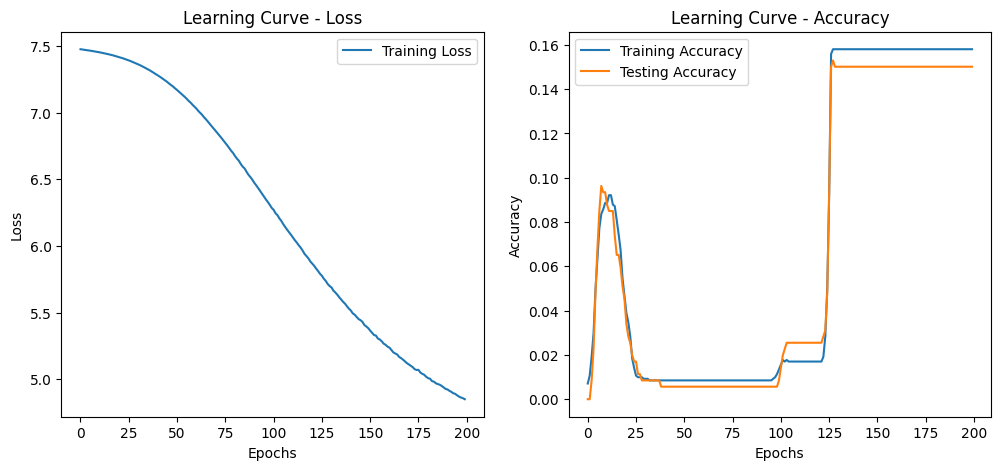

In [948]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Create mappings for ports
port_to_index = {port: idx for idx, port in enumerate(pre_df['place.unlocode'].unique())}
pre_df['cur_port_index'] = pre_df['place.unlocode'].map(port_to_index)
pre_df['next_port_index'] = pre_df['next_place'].map(port_to_index)

# Ensure the edge_index is correctly formatted
edge_index = torch.tensor([pre_df['cur_port_index'].values, pre_df['next_port_index'].values], dtype=torch.long)

# Prepare labels
labels = torch.tensor(pre_df['next_port_index'].values, dtype=torch.long)

# Ensure nodes are one-hot encoded for simplicity
num_nodes = len(port_to_index)
node_features = torch.eye(num_nodes)

# Create graph data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

# Create training and testing masks
train_mask, test_mask = train_test_split(range(num_nodes), test_size=0.2, random_state=42)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

def train(model, optimizer, criterion, data, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    out = model(data)
    _, pred = out[mask].max(dim=1)
    correct = pred.eq(data.y[mask]).sum().item()
    return correct / mask.size(0)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.001],
    'hidden_channels': [16, 32],
    'dropout': [0.5, 0.2]
}

best_params = None
best_test_acc = 0

for lr in param_grid['learning_rate']:
    for hidden_channels in param_grid['hidden_channels']:
        for dropout in param_grid['dropout']:
            model = GCN(num_features=num_nodes, hidden_channels=hidden_channels, num_classes=num_nodes, dropout=dropout)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = torch.nn.CrossEntropyLoss()

            train_losses, train_accuracies, test_accuracies = [], [], []

            for epoch in range(200):
                train_loss = train(model, optimizer, criterion, data, train_mask)
                train_acc = evaluate(model, data, train_mask)
                test_acc = evaluate(model, data, test_mask)

                train_losses.append(train_loss)
                train_accuracies.append(train_acc)
                test_accuracies.append(test_acc)

                print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Accuracy {train_acc:.4f}, Test Accuracy {test_acc:.4f}')

            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_params = {
                    'learning_rate': lr,
                    'hidden_channels': hidden_channels,
                    'dropout': dropout
                }

print("Best Parameters:", best_params)
print("Best Test Accuracy:", best_test_acc)

# Plotting Learning and Validation Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1: Train Loss 7.4752, Train Accuracy 0.1290, Test Accuracy 0.1161
Epoch 2: Train Loss 7.4551, Train Accuracy 0.1311, Test Accuracy 0.1218
Epoch 3: Train Loss 7.4319, Train Accuracy 0.1077, Test Accuracy 0.0963
Epoch 4: Train Loss 7.4047, Train Accuracy 0.0425, Test Accuracy 0.0510
Epoch 5: Train Loss 7.3730, Train Accuracy 0.0092, Test Accuracy 0.0057
Epoch 6: Train Loss 7.3367, Train Accuracy 0.0064, Test Accuracy 0.0000
Epoch 7: Train Loss 7.2958, Train Accuracy 0.0050, Test Accuracy 0.0000
Epoch 8: Train Loss 7.2479, Train Accuracy 0.0035, Test Accuracy 0.0000
Epoch 9: Train Loss 7.1947, Train Accuracy 0.0035, Test Accuracy 0.0000
Epoch 10: Train Loss 7.1354, Train Accuracy 0.0035, Test Accuracy 0.0000
Epoch 11: Train Loss 7.0704, Train Accuracy 0.0035, Test Accuracy 0.0000
Epoch 12: Train Loss 6.9993, Train Accuracy 0.0043, Test Accuracy 0.0000
Epoch 13: Train Loss 6.9211, Train Accuracy 0.0043, Test Accuracy 0.0028
Epoch 14: Train Loss 6.8339, Train Accuracy 0.0050, Test Acc

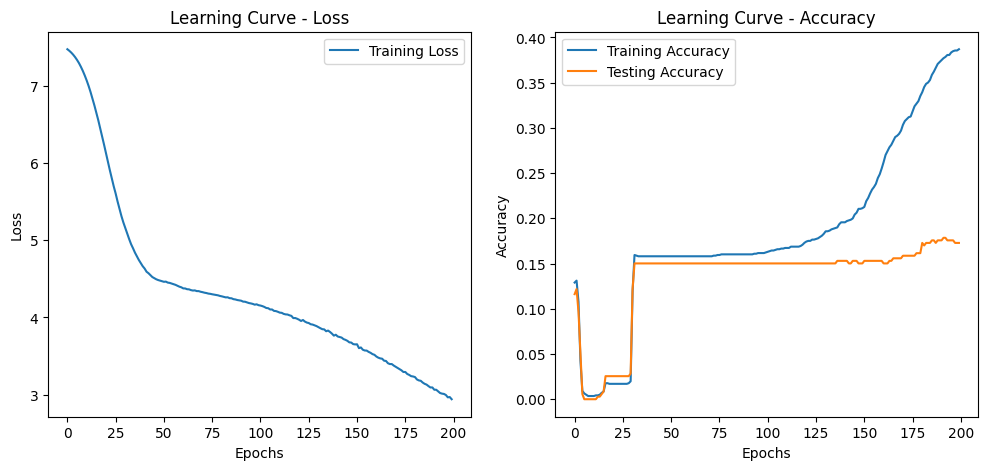

In [950]:
# using the best hyperparameters
best_train_loss = []
best_train_acc = []
best_test_acc = []
model = GCN(num_features=num_nodes, hidden_channels=best_params.get('hidden_channels'), num_classes=num_nodes, dropout=best_params.get('dropout'))
optimizer = torch.optim.Adam(model.parameters(), lr=best_params.get('learning_rate'))
criterion = torch.nn.CrossEntropyLoss()

train_losses, train_accuracies, test_accuracies = [], [], []

for epoch in range(200):
    train_loss = train(model, optimizer, criterion, data, train_mask)
    train_acc = evaluate(model, data, train_mask)
    test_acc = evaluate(model, data, test_mask)

    best_train_loss.append(train_loss)
    best_train_acc.append(train_acc)
    best_test_acc.append(test_acc)

    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Accuracy {train_acc:.4f}, Test Accuracy {test_acc:.4f}')

# Plotting Learning and Validation Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(best_train_loss, label='Training Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_train_acc, label='Training Accuracy')
plt.plot(best_test_acc, label='Testing Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1: Train Loss 7.4749, Train Accuracy 0.1602, Test Accuracy 0.1473
Epoch 2: Train Loss 7.4521, Train Accuracy 0.1602, Test Accuracy 0.1501
Epoch 3: Train Loss 7.4242, Train Accuracy 0.1588, Test Accuracy 0.1501
Epoch 4: Train Loss 7.3862, Train Accuracy 0.1588, Test Accuracy 0.1501
Epoch 5: Train Loss 7.3353, Train Accuracy 0.1580, Test Accuracy 0.1501
Epoch 6: Train Loss 7.2662, Train Accuracy 0.1580, Test Accuracy 0.1501
Epoch 7: Train Loss 7.1802, Train Accuracy 0.1580, Test Accuracy 0.1501
Epoch 8: Train Loss 7.0904, Train Accuracy 0.1580, Test Accuracy 0.1501
Epoch 9: Train Loss 6.9804, Train Accuracy 0.1580, Test Accuracy 0.1501
Epoch 10: Train Loss 6.8578, Train Accuracy 0.1580, Test Accuracy 0.1501
Epoch 11: Train Loss 6.7179, Train Accuracy 0.1580, Test Accuracy 0.1501
Epoch 12: Train Loss 6.5641, Train Accuracy 0.1580, Test Accuracy 0.1501
Epoch 13: Train Loss 6.4289, Train Accuracy 0.1580, Test Accuracy 0.1501
Epoch 14: Train Loss 6.2562, Train Accuracy 0.1580, Test Acc

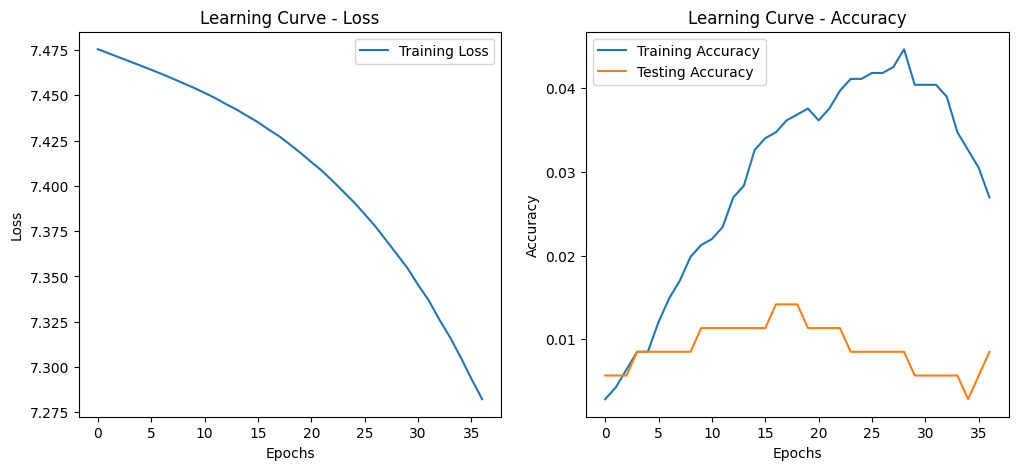

In [954]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming pre_df is your preprocessed DataFrame
# Create mappings for ports
port_to_index = {port: idx for idx, port in enumerate(pre_df['place.unlocode'].unique())}
pre_df['cur_port_index'] = pre_df['place.unlocode'].map(port_to_index)
pre_df['next_port_index'] = pre_df['next_place'].map(port_to_index)

# Ensure the edge_index is correctly formatted
edge_index = torch.tensor([pre_df['cur_port_index'].values, pre_df['next_port_index'].values], dtype=torch.long)

# Prepare labels
labels = torch.tensor(pre_df['next_port_index'].values, dtype=torch.long)

# Ensure nodes are one-hot encoded for simplicity
num_nodes = len(port_to_index)
node_features = torch.eye(num_nodes)

# Create graph data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

# Create training and testing masks
train_mask, test_mask = train_test_split(range(num_nodes), test_size=0.2, random_state=42)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

class ImprovedGCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout):
        super(ImprovedGCN, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)  # Try SAGEConv layer
        self.conv2 = GATConv(hidden_channels, num_classes, heads=1)  # Try GATConv layer
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

def train(model, optimizer, criterion, data, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    out = model(data)
    _, pred = out[mask].max(dim=1)
    correct = pred.eq(data.y[mask]).sum().item()
    return correct / mask.size(0)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.001],
    'hidden_channels': [16, 32],
    'dropout': [0.5, 0.2],
    'weight_decay': [0, 5e-4]
}

best_params = None
best_test_acc = 0

for lr in param_grid['learning_rate']:
    for hidden_channels in param_grid['hidden_channels']:
        for dropout in param_grid['dropout']:
            for wd in param_grid['weight_decay']:
                model = ImprovedGCN(num_features=num_nodes, hidden_channels=hidden_channels, num_classes=num_nodes, dropout=dropout)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                criterion = torch.nn.CrossEntropyLoss()

                train_losses, train_accuracies, test_accuracies = [], [], []

                best_test_acc = 0
                best_epoch = 0
                patience = 20
                early_stop_counter = 0

                for epoch in range(200):
                    train_loss = train(model, optimizer, criterion, data, train_mask)
                    train_acc = evaluate(model, data, train_mask)
                    test_acc = evaluate(model, data, test_mask)

                    train_losses.append(train_loss)
                    train_accuracies.append(train_acc)
                    test_accuracies.append(test_acc)

                    if test_acc > best_test_acc:
                        best_test_acc = test_acc
                        best_epoch = epoch
                        early_stop_counter = 0
                    else:
                        early_stop_counter += 1

                    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Accuracy {train_acc:.4f}, Test Accuracy {test_acc:.4f}')

                    if early_stop_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break

                # Save plots for the current hyperparameter combination
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_losses, label='Training Loss')
                plt.title(f'Learning Curve - Loss (lr={lr}, hidden={hidden_channels}, dropout={dropout}, wd={wd})')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()

                plt.subplot(1, 2, 2)
                plt.plot(train_accuracies, label='Training Accuracy')
                plt.plot(test_accuracies, label='Testing Accuracy')
                plt.title(f'Learning Curve - Accuracy (lr={lr}, hidden={hidden_channels}, dropout={dropout}, wd={wd})')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.legend()
                
                plt.tight_layout()
                plt.savefig(f'learning_curves_lr_{lr}_hidden_{hidden_channels}_dropout_{dropout}_wd_{wd}.png')
                plt.close()

                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    best_params = {
                        'learning_rate': lr,
                        'hidden_channels': hidden_channels,
                        'dropout': dropout,
                        'weight_decay': wd
                    }

print("Best Parameters:", best_params)
print("Best Test Accuracy:", best_test_acc)

# Plotting the best learning curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()